In [502]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [503]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

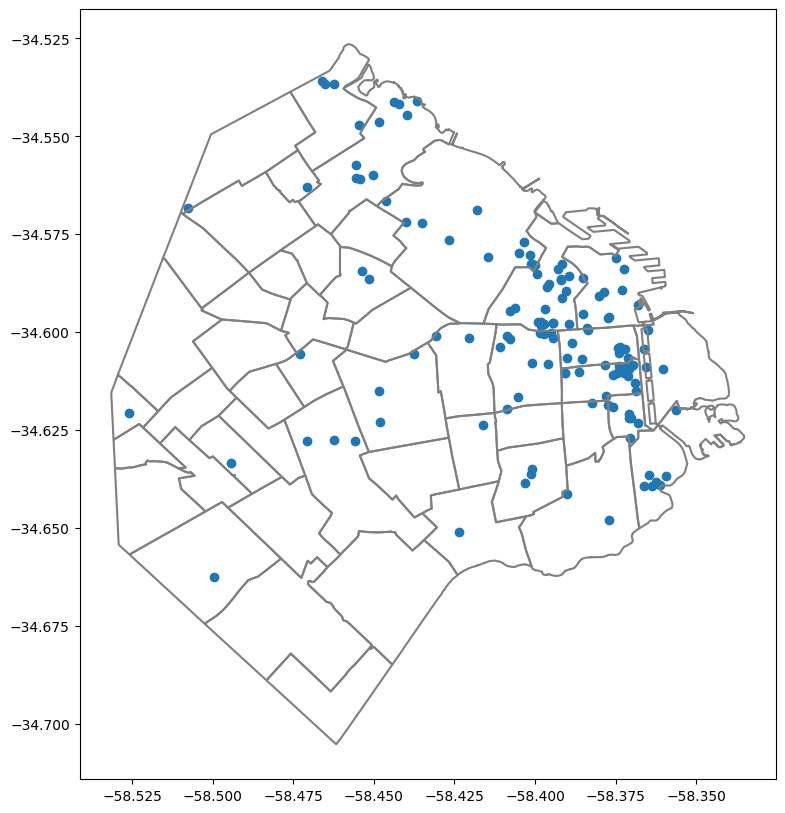

In [504]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [505]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [506]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [507]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

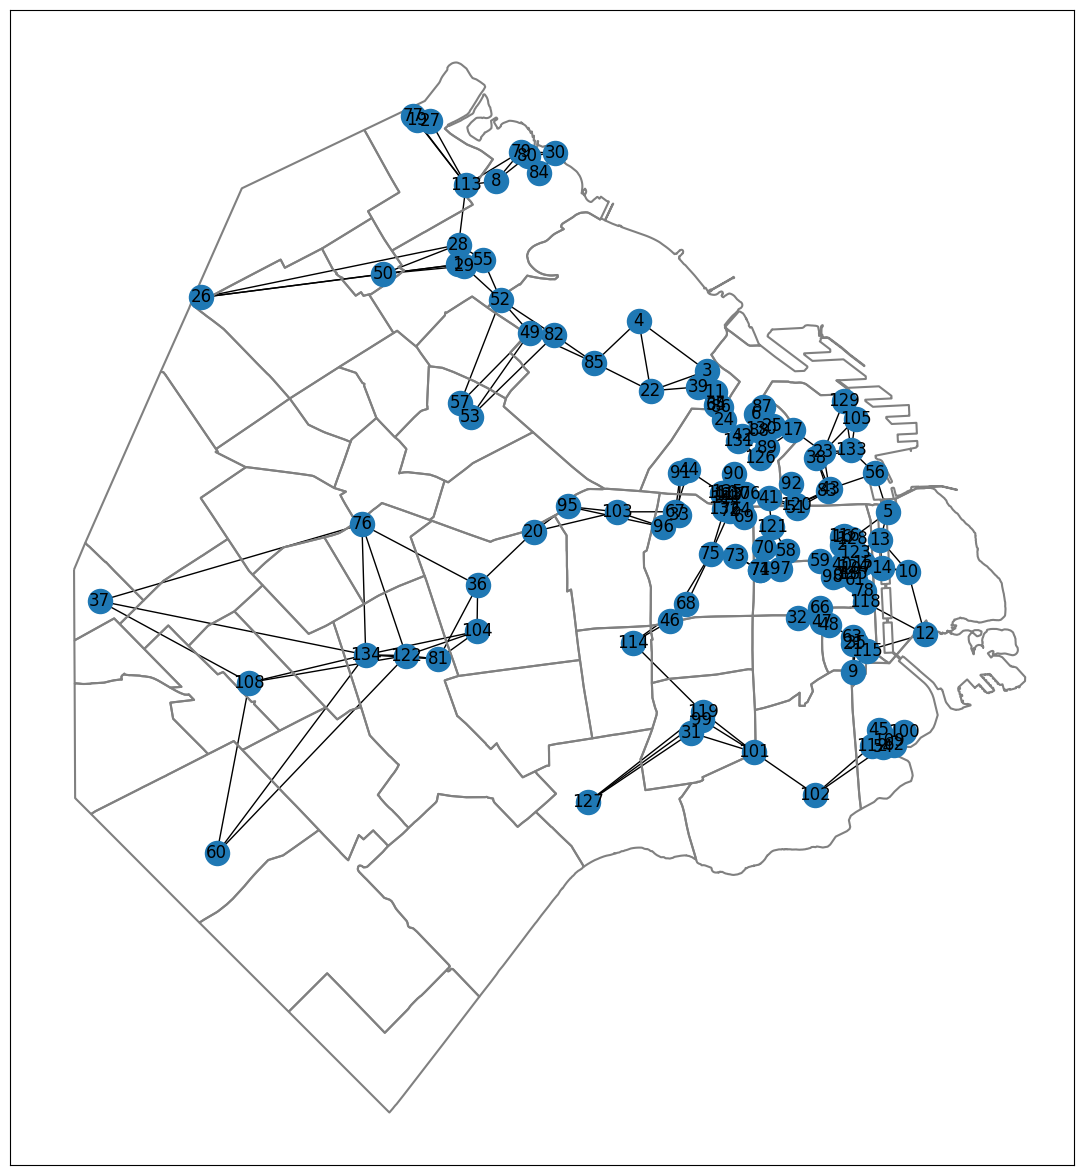

In [508]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

---

# Resolución del TP 1

## Punto 1: 
----
Partiendo de la ecuación

$$
\mathbf{p} = (1-\alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}
$$

muestre que el vector de rankings **p** es solución de la ecuación     $M\mathbf{p} = \mathbf{b}$  , con    $M = \frac{N}{\alpha}(I - (1-\alpha)C)$    y    $\mathbf{b} = \mathbf{1}$  .


### Resolución

La ecuación es:

$$
\mathbf{p} = (1-\alpha)C\mathbf{p} + \frac{\alpha}{N}\mathbf{1},
$$

luego:

$$\mathbf{p} - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\mathbf{p}I - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$(I - (1-\alpha)C)\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\frac{N}{\alpha}(I - (1-\alpha)C)\mathbf{p} = \mathbf{1}$$

y con $M = \frac{N}{\alpha}(I - (1-\alpha)C)$ resulta lo pedido: $M\mathbf{p} = \mathbf{b} = \mathbf{1}$.


## Punto 2:
----
¿Qué condiciones se deben cumplir para que exista una única solución a la ecuación del
punto anterior? ¿Se cumplen estas condiciones para la matriz $M$ tal como fue construida
para los museos, cuando $0 < \alpha < 1$? Demuestre que se cumplen o dé un contraejemplo.


Dado el ítem anterior, la ecuación $Mp = 1$ tendrá solución única cuando $M$ sea inversible. Una condición necesaria y suficiente para esto es que el núcleo de $M$ sea $\{0\}$.

Primero, usando el tip dado en clase, pruebo:

$$
\text{Si} \quad B \in \mathbb{R}^{n \times n} \quad \text{y} \quad \|B\|_1 < 1 \quad \text{entonces} \quad (I-B) \quad \text{es inversible}.
$$

Supongamos que existe $(I-B)^{-1}$. Entonces, si existiera $x \neq 0$ en $\mathbb{R}^{n}$ tal que $(I-B)x = 0$, tendríamos:

$$
x - Bx = 0
$$

lo que equivale a

$$
x = Bx.
$$

Uso la norma-1 (que preserva la igualdad) y puedo suponer que $\|x\|_1 = 1$. Entonces:

$$
\|x\|_1 = \|Bx\|_1 \quad \Rightarrow \quad 1 = \|Bx\|_1.
$$

Además, se cumple que $\|Bx\|_1 \leq \|B\|_1 \|x\|_1$ y, usando la hipótesis $\|B\|_1 < 1$, resulta:

$$
\|Bx\|_1 \leq \|B\|_1 \|x\|_1 = \|B\|_1 < 1.
$$

Por lo tanto, tenemos que:

$$
\|Bx\|_1 = 1 \quad \text{y} \quad \|Bx\|_1 < 1,
$$

lo cual es imposible. Como lo único que supusimos fue que $x \neq 0$, debe ser entonces que solamente se cumple $(I-B)x = 0$ si $x = 0$. Por lo tanto, $(I-B)$ es inversible.

---

Volviendo al problema original: $Mp = 1$ tendrá solución única si la matriz $M$ resulta inversible, es decir, si $(I - (1-\alpha)C)$ es inversible.

Por un lado, observamos que $\|C\|_1 = 1$ dado que, por definición, sus columnas suman 1. Por otro lado, como $0 < \alpha < 1$, se cumple que $1-\alpha < 1$.

Es decir:

$$
\|(1-\alpha)C\|_1 = (1-\alpha)\|C\|_1 < 1.
$$

Esto es análogo al problema anterior sobre la existencia de $(I-B)^{-1}$, por lo tanto $(I - (1-\alpha)C)^{-1}$ existe, y la solución $p$ es única con la matriz $M$ y $\alpha$ así definidos.


## Punto 3:
----
Usando la factorización $LU$ implementada, encuentre el vector $\mathbf{p} = M^{-1} \mathbf{b}$ en los siguientes casos:

**a.** Construyendo la red conectando a cada museo con sus $m = 3$ vecinos más cercanos, calculen el Page Rank usando $\alpha = 1/5$. Visualicen la red asignando un tamaño a cada nodo proporcional al Page Rank que le toca.

**b.** Construyendo la red conectando a cada museo con sus $m$ vecinos más cercanos, para $m = 1, 3, 5, 10$ y usando $\alpha = 1/

**c.** Para $m = 5$, considerando los valores de $\alpha = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7$

-----

Usando los valores de $\mathbf{p}$ obtenidos para cada caso,

**a.** Identifiquen los 3 museos más centrales (para cada $m$ y cada $\alpha$) y grafiquen sus puntajes (valores de Page Rank) en función del parámetro a variar (es decir, en función de $m$ o de $\alpha$). ¿Son estables las posiciones en el ranking? Describa los distintos patrones que observa, identificando qué ubicaciones son relevantes en cada caso. ¿Hay museos que sólo son relevantes en redes con pocas conexiones? ¿O museos que se vuelven más relevantes mientras más conexiones aparecen?

**b.** Construyan visualizaciones del mapa, usando el Page Rank para representar el tamaño de cada museo. ¿Qué regiones se vuelven más predominantes al aumentar $\alpha$? ¿Y al aumentar $m$?


In [509]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import template_funciones as tf
from IPython.display import display
importlib.reload(tf)

<module 'template_funciones' from 'c:\\Users\\mazze\\Documents\\GIT\\ALC2025-1c-TP1\\template_funciones.py'>

In [510]:
# Definimos los valores de m a analizar
valores_m = [1, 3, 5, 10]
alfa_fijo = round(1/5, 5)

# Diccionarios para guardar matrices de adyacencia, grafos y pageranks
adyacencias_m = {}
grafos_m = {}
pageranks_m = {}

for m in valores_m:
    A = tf.construye_adyacencia(D, m)
    adyacencias_m[m] = A
    grafos_m[m] = nx.from_numpy_array(A)
    pageranks_m[m] = tf.calcula_pagerank(A, alfa_fijo)

# PageRank para distintos valores de α con m=5 fijo
valores_alfa = [round(6/7, 5), round(4/5, 5), round(2/3, 5), round(1/2, 5), round(1/3, 5), round(1/5, 5), round(1/7, 5)]
m_fijo = 5
A_fijo = adyacencias_m[m_fijo]  # Ya lo calculamos arriba

pageranks_alfa = {}

for alfa in valores_alfa:
    alfa_key = round(alfa, 5)  # Redondeamos para evitar errores al usar un float como key
    p = tf.calcula_pagerank(A_fijo, alfa)
    pageranks_alfa[alfa_key] = p
    
# Layouts
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (x, y) for i, (x, y) in enumerate(zip(coords['x'], coords['y']))}

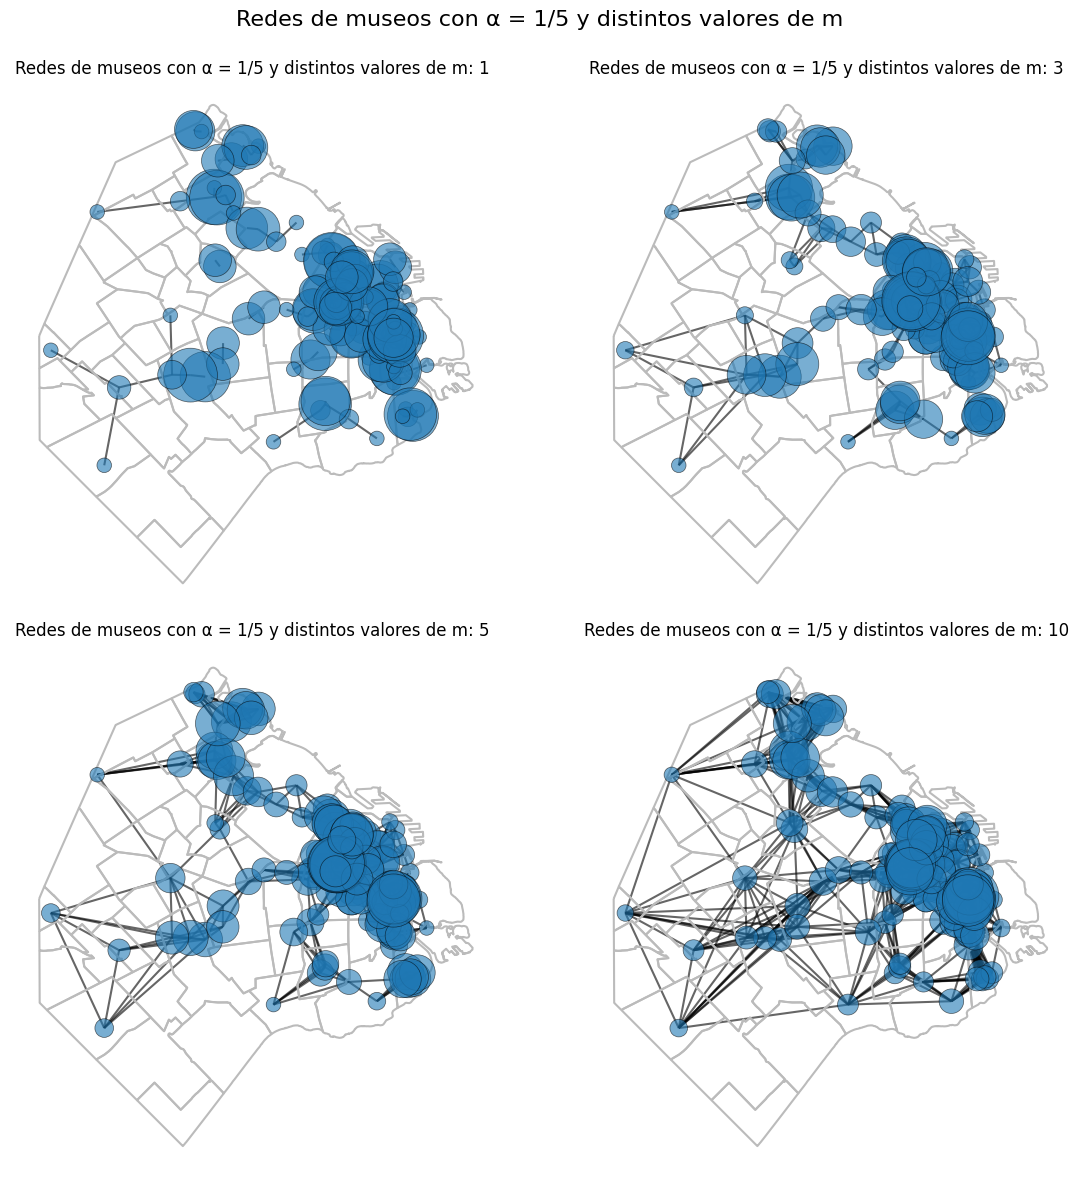

In [511]:
# Mostrar redes para distintos m (con α = 1/5 fijo)
tf.graficar_redes_museos_set(
    grafos=grafos_m,
    pageranks=pageranks_m,
    G_layout=G_layout,
    barrios=barrios,
    titulo_general="Redes de museos con α = 1/5 y distintos valores de m"
)

En estos gráficos se observa cómo varía la red de museos al modificar el parámetro $m$, que indica con cuántos vecinos se conecta cada museo (sus $m$ más cercanos). A medida que $m$ aumenta, la red se vuelve progresivamente más densa, y eso tiene consecuencias sobre la distribución del PageRank.

Con valores bajos de $m$ (por ejemplo, $m = 1$ o $m = 3$), la red presenta una estructura más fragmentada: aparecen pequeñas zonas relativamente autónomas, en las que ciertos museos son centrales dentro de su subregión (por ejemplo, museos ubicados en Caballito y Flores, la zona norte de CABA y Microcentro). Esto se refleja en el PageRank, donde varios nodos periféricos en el grafo completo tienen una alta centralidad dentro de su grupo local.

Sin embargo, a medida que $m$ aumenta (por ejemplo, en $m = 10$), estas subregiones comienzan a conectarse entre sí y se forma una estructura más integrada. En este contexto, los nodos centrales del Microcentro y los de la zona norte empiezan a dominar el ranking, desplazando a aquellos que antes eran importantes solo dentro de su vecindario. Es decir, pasamos de una red con múltiples polos locales de centralidad a una red con una o dos zonas centrales más clara y dominante.

Este comportamiento muestra cómo el valor de $m$ influye en el grado de descentralización de la red: con $m$ bajos emergen estructuras locales, mientras que con $m$ altos la red converge hacia un patrón de conectividad más global, en el que solo unos pocos nodos concentran la mayor parte del PageRank.


---

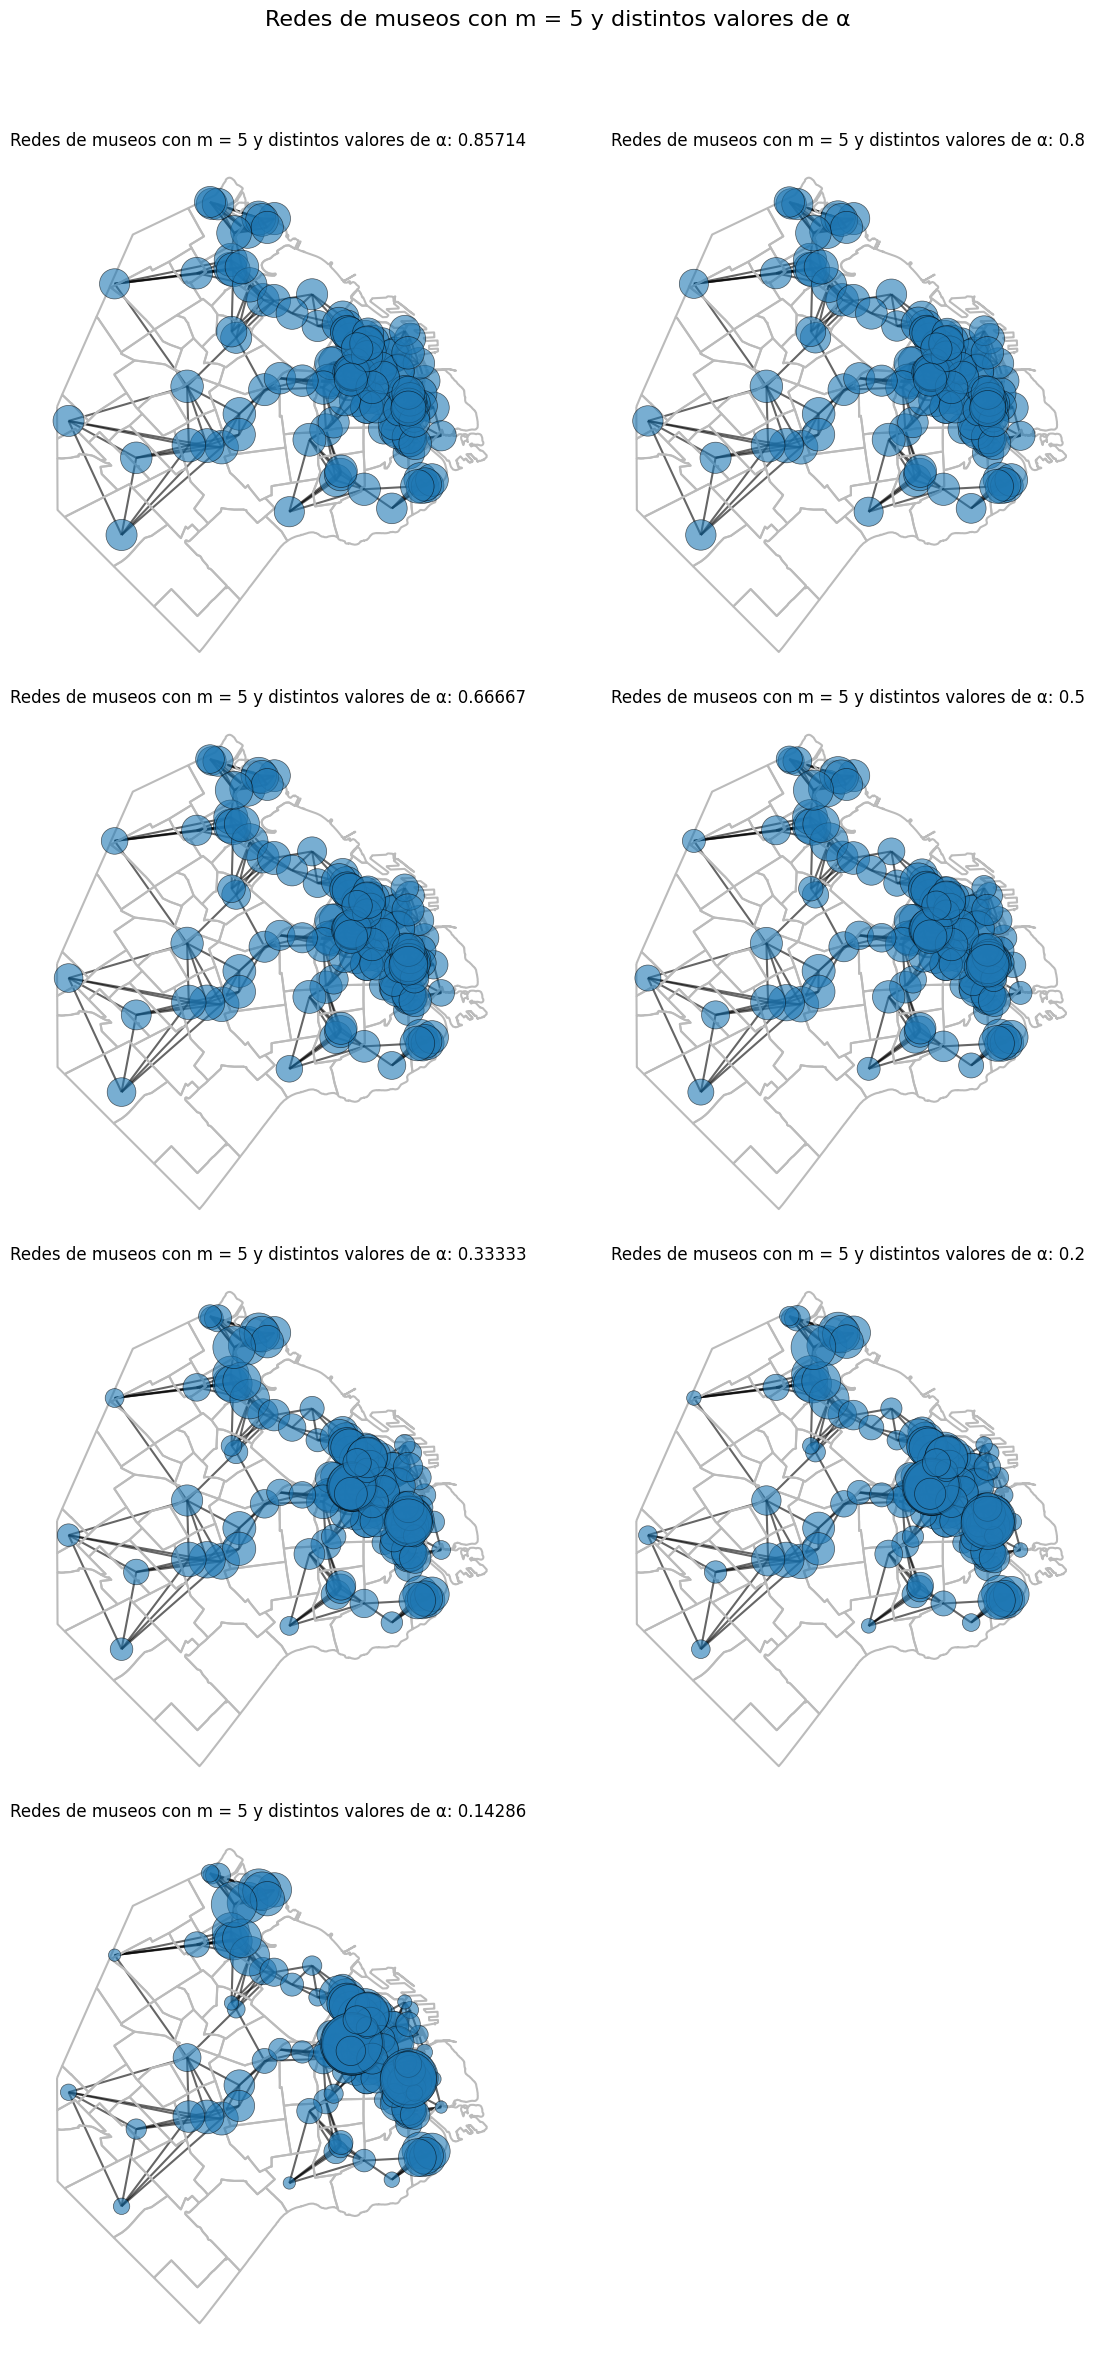

In [512]:
# Mostrar redes para distintos α (con m = 5 fijo)
# Creamos un diccionario de grafos con m=5 fijo
grafos_alfa = {round(alfa, 5): grafos_m[5] for alfa in valores_alfa}

tf.graficar_redes_museos_set(
    grafos=grafos_alfa,
    pageranks=pageranks_alfa,
    G_layout=G_layout,
    barrios=barrios,
    titulo_general="Redes de museos con m = 5 y distintos valores de α"
)

En este caso, como el valor de $m$ está fijo en 5, todos los grafos tienen exactamente las mismas conexiones entre museos. Lo que cambia entre gráficos es el valor del parámetro $\alpha$, que controla la probabilidad de que un caminante reinicie su recorrido en un nodo aleatorio.

Cuando $\alpha$ está cerca de 1, por ejemplo $\alpha = \frac{6}{7}$, hay mucha probabilidad de reiniciar la caminata en cualquier museo. Eso hace que los valores de PageRank se repartan de forma bastante uniforme: todos los nodos tienen más o menos el mismo tamaño. En cambio, cuando $\alpha$ se acerca a 0, como en $\alpha = \frac{1}{7}$, el caminante sigue los enlaces de la red casi sin reiniciar, y eso acentúa las diferencias entre nodos. En ese caso, los museos más bien ubicados o con más caminos que llegan a ellos se destacan mucho más.

En resumen, cuanto más chico es $\alpha$, más influye la estructura de la red en el resultado del PageRank. Y cuanto más grande es $\alpha$, más uniforme es la distribución del ranking entre los nodos.

---

Para la segunda parte, haremos primero el análisis para $m=5$ y $\alpha = \frac{1}{5}$ y haremos variar $m$ dejando $\alpha$ fijo.

In [513]:
# Obtenemos el top 3 de museos más centrales para m = 5 y 𝛼 = 1/5
p_copy = pageranks_m[5].copy()
top_idx = []

for i in range(3):
    max_val = -1
    max_idx = -1

    # Recorremos p_copy para buscar el maximo y su posicion
    for idx in range(len(p_copy)):
        if p_copy[idx] > max_val:
            max_val = p_copy[idx]
            max_idx = idx
        
    top_idx.append(max_idx)
    print(f"{i+1}° → Museo #{max_idx} con PageRank = {max_val:.4f}")
        
    # Lo sacamos para encontrar el resto del Top
    p_copy[max_idx] = -1

1° → Museo #93 con PageRank = 0.0217
2° → Museo #125 con PageRank = 0.0216
3° → Museo #117 con PageRank = 0.0211


Ahora analizaremos la evolución de estos 3 museos de referencia al variar $m$.

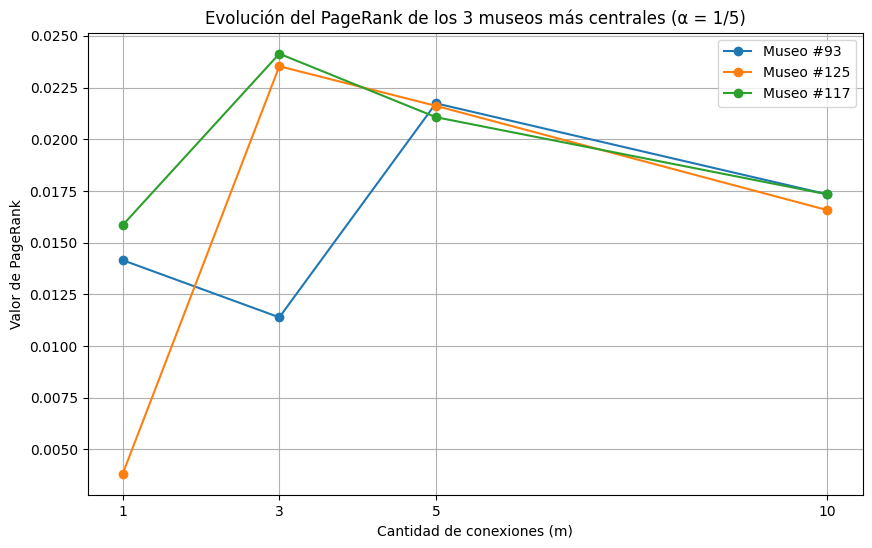

In [514]:
# Inicializamos un diccionario vacío para guardar la evolución de cada museo
evolucion_p_m = {idx: [] for idx in top_idx}

# Recorremos cada valor de m
for m in valores_m:
    p = pageranks_m[m]
    for idx in top_idx:
        evolucion_p_m[idx].append(p[idx])  # Guardamos el PageRank correspondiente
        
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_m, evolucion_p_m[idx], marker='o', label=f"Museo #{idx}")

# Vector de etiquetas
labels_m = ["1", "3", "5", "10"]
plt.xticks(valores_m, labels_m)  # Aseguramos que se usen los valores como etiquetas explícitas

plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Valor de PageRank")
plt.title("Evolución del PageRank de los 3 museos más centrales (α = 1/5)")
plt.grid(True)
plt.legend()
plt.show()

Se aprecia que, en general, los valores de PageRank tienden a incrementarse cuando pasamos de $m = 1$ a $m = 3$, y luego decrecen levemente al seguir aumentando $m$ a $5$ y $10$. Esto puede interpretarse como un efecto de dispersión: con pocas conexiones, la importancia se concentra en unos pocos nodos; a medida que se agregan más enlaces, la centralidad se redistribuye y los valores de PageRank tienden a equilibrarse entre más museos.

---

Hacemos lo mismo pero en función de $\alpha$:

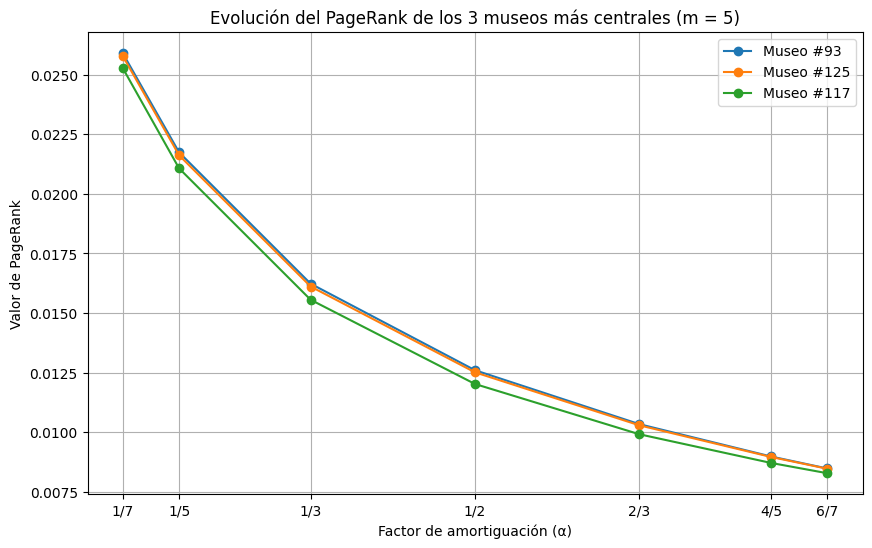

In [515]:
# Inicializamos un diccionario vacío para guardar la evolución de cada museo
evolucion_p_alfa = {idx: [] for idx in top_idx}

# Recorremos cada valor de m
for m in valores_alfa:
    p = pageranks_alfa[m]
    for idx in top_idx:
        evolucion_p_alfa[idx].append(p[idx])  # Guardamos el PageRank correspondiente
        
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_alfa, evolucion_p_alfa[idx], marker='o', label=f"Museo #{idx}")

# Vector de etiquetas
labels_alfa = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"]
plt.xticks(valores_alfa, labels_alfa)

plt.xlabel("Factor de amortiguación (α)")
plt.ylabel("Valor de PageRank")
plt.title("Evolución del PageRank de los 3 museos más centrales (m = 5)")
plt.grid(True)
plt.legend()
plt.show()

Se ve que cuanto más grande es $\alpha$, más se reparten los valores de PageRank entre todos los nodos (recordemos que p es un vector estocástico), y los más centrales bajan un poco. Esto pasa porque al aumentar $\alpha$, el modelo depende más de cómo está conectada la red, y menos del "salto aleatorio". En cambio, cuando $\alpha$ es chico, se favorece más a los nodos a los que se llega seguido, y eso hace que se destaquen más en el ranking.

---

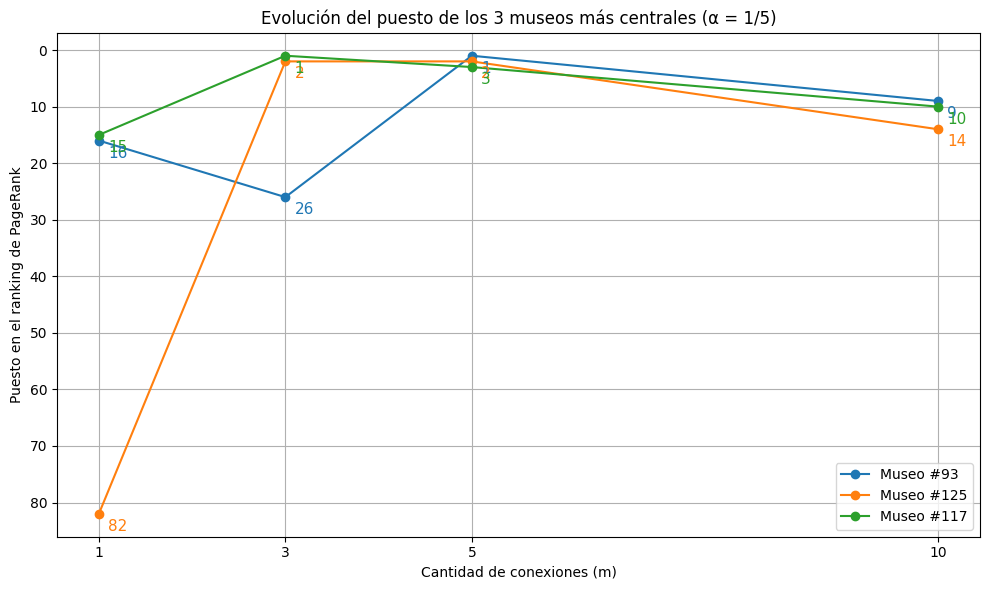

In [516]:
# Diccionario para guardar la evolución del puesto de cada museo
puestos_m = {idx: [] for idx in top_idx}

for m in valores_m:
    p = pageranks_m[m]
    
    # Vector de índices ordenados de mayor a menor
    ranking = np.argsort(p)[::-1]  
    
    for idx in top_idx:
        # np.where devuelve los índices donde se cumple la condición del argumento
        puesto = np.where(ranking == idx)[0][0] + 1  # +1 para que el ranking empiece en 1
        puestos_m[idx].append(puesto)


colores = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))

for color, idx in zip(colores, top_idx):
    puestos = puestos_m[idx]
    plt.plot(valores_m, puestos, marker='o', label=f"Museo #{idx}", color=color)

    for x, y in zip(valores_m, puestos):
        plt.text(x + 0.1, y + 3, str(y), fontsize=11, color=color)

plt.xticks(valores_m, labels_m)
plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Puesto en el ranking de PageRank")
plt.title("Evolución del puesto de los 3 museos más centrales (α = 1/5)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Podemos observar que al aumentar el valor de $m$ (entre 1 y 10), se observa una notable inestabilidad en el ranking de los museos más centrales. Uno de los museos que ocupa el segundo puesto con $m = 5$ cae al puesto 82 cuando m = 1. Esta gran variación sugiere que el número de conexiones tiene un impacto decisivo en la estructura de la red: con pocos enlaces ($m$ chico), la red es más local y sensible a cambios puntuales; en cambio, a medida que $m$ crece, el ranking se estabiliza y los museos centrales tienden a mantener posiciones altas. A partir de $m = 5$, los rankings se vuelven más estables entre sí.

---

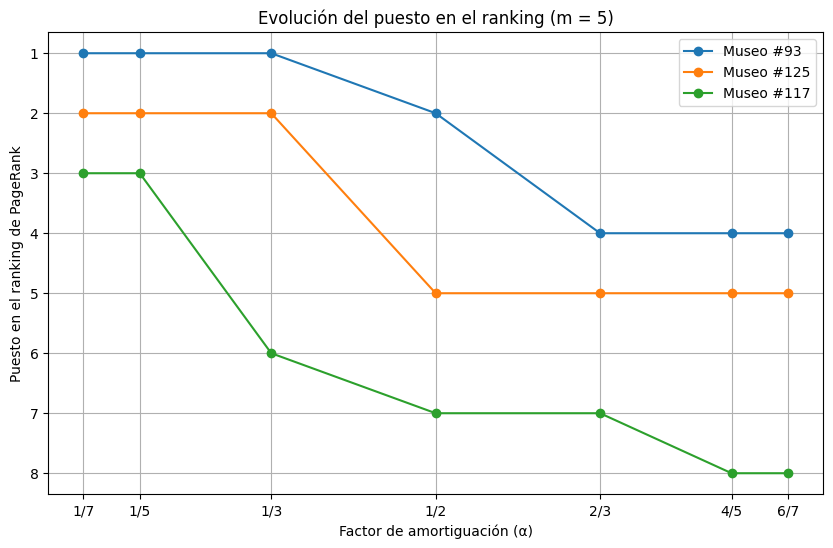

In [517]:
# Diccionario para guardar la evolución del puesto de cada museo
puestos_alfa = {idx: [] for idx in top_idx}

for alfa in valores_alfa:
    p = pageranks_alfa[alfa]
    
    # Vector de índices ordenados de mayor a menor
    ranking = np.argsort(p)[::-1]
    
    for idx in top_idx:
        # np.where devuelve los índices donde se cumple la condición del argumento
        puesto = np.where(ranking == idx)[0][0] + 1  # +1 para que el ranking empiece en 1
        puestos_alfa[idx].append(puesto)

# Graficamos los resultados
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_alfa, puestos_alfa[idx], marker='o', label=f"Museo #{idx}")

plt.xticks(valores_alfa, labels_alfa)  # Ya habías definido estas etiquetas como fracciones
plt.xlabel("Factor de amortiguación (α)")
plt.ylabel("Puesto en el ranking de PageRank")
plt.title("Evolución del puesto en el ranking (m = 5)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

Al variar $\alpha$ (entre 1/7 y 6/7), se evidencia una estabilidad mucho mayor en los puestos de los museos más centrales. Los tres museos analizados mantienen posiciones altas con variaciones pequeñas y progresivas. Esto indica que el PageRank es menos sensible a cambios en $\alpha$ (dentro del rango considerado), y que los museos más importantes siguen siendo favorecidos en el ranking incluso cuando el peso relativo de la caminata aleatoria frente al salto aleatorio varía.

---

## Punto 4:

Si $V_{0}$ es la distribución inicial, o cantidad inicial de visitantes en cada museo, y considero la matriz C, entonces para un elemento i cualquiera de $CV_{0}$, tengo que i = $c_{1,i}*v_{1} + c_{2,i}*v_{2} + \ldots + c_{n,i}*v_{n}$ que no es otra cosa que la suma de la cantidad de visitantes que cada museo distinto del i (si i=j $c_{ij} = 0$) le aporta al i.

De forma análoga pero partiendo de otra cantidad inicial $V_{1} = CV_{0}$ nos dara la cantidad de visitantes por museo luego de 2 pasos.
Al final, como menciona el tip, $C^{k}V_{0} = V_{k}$ nos dara la cantida de visitantes por museo luego de k pasos.

Dada la matriz $B$ y $V_{0}$ tengo que: $Bv_{0} = C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$. Por lo mencionado antes, resulta que, por ejemplo: $C^{0}v_{0} + C^{1}v_{0}$ será la cantidad total de gente que visitó cada museo luego de dos pasos.
En general $C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$ da la totalidad de visitantes por museo, es decir, w, luego de k pasos.
Si asumo la existencia de $B^{-1}$, para cada r, entonces para cada total de visitantes por museo w tengo la distribución inicial $V_{0}$ que lo generó.

## Punto 5:

Usando la ecuación  

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

y suponiendo que las personas dan \( $r = 3$ \) pasos en la red de museos, calcular la cantidad total de visitantes que entraron en la red, $
\|\mathbf{v}\|_1 $
, a partir del vector $ \mathbf{w}\ $ provisto en el archivo `visitas.txt`. Usar para esto la matriz de transiciones definida por la ecuación:

$$
C_{ji} = P(i \to j) = \frac{f(d_{ij})}{\sum_{k=1,\, k \ne i}^{N} f(d_{ik})}
$$


Para esto:

- Construya una función `calcula_matriz_C_continua` que reciba la matriz de distancias entre museos $ D $ y retorne la matriz $ C $ definida en la ecuación anterior.
- Construya una función `calcula_B(C, r)` que reciba la matriz $ C $ y el número de pasos $ r $ como argumento, y retorne la matriz $B$ de la ecuación:
$
\mathbf{v} = B^{-1} \mathbf{w}
$.
- Utilice la función `calculaLU` para resolver la ecuación:

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

In [518]:
w = np.loadtxt("visitas.txt") #Arma vector w a partir del archivo
C = tf.calcula_matriz_C_continua(D) # Construye la matriz de transiciones C
B = tf.calcula_B(C, 3) # Calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes suponiendo que cada visitante realizó 3 pasos
v = tf.resolver_con_LU(B, w)

visitantes_totales = np.sum(np.abs(v)) # Calcula norma 1 de v
print("Si las personas dan 3 pasos en la red de museos la cantidad total de visitantes que entraron en la red es ", visitantes_totales)

Si las personas dan 3 pasos en la red de museos la cantidad total de visitantes que entraron en la red es  136605.0


## Punto 6:

Supongan que se enteran de que el número total de visitantes por museo $ \mathbf{w} $ tiene un error del 5%, y necesitan estimar cómo se propaga ese error a la estimación del número inicial $ \mathbf{v} $ de visitantes. Llamemos $ \tilde{\mathbf{w}} $ y $ \tilde{\mathbf{v}} $ los valores reales para el total de visitas y el total de primeras visitas respectivamente.

Si expresamos este problema usando el número de condición, tenemos que:

$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq \text{cond}_1(B) \cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$

Calcule el número de condición de $ B $ y estime la cota para el error de estimación de $ \mathbf{v} $.

In [519]:
cond_B = tf.condicion_1_por_LU(B)# Número de condición de B
error_v = cond_B * 0.05 # La cota para el error de estimación de v

print("El número de condición 1 de B es", cond_B)
print("La cota para el error de estimación de v es", error_v)

El número de condición 1 de B es 5.051771176665007
La cota para el error de estimación de v es 0.2525885588332503


---

# Resolución del TP 2

## Punto 1. Autovectores y autovalores de $L$ y $R$

### a. Mostrar que el vector $\mathbf{1}$ es autovector de $L$ y $R$

Sea $\mathbf{1}$ el vector columna con todos sus componentes iguales a 1, es decir:
$$
\mathbf{1} = \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix}
$$

Recordemos que la matriz laplaciana se define como $L = K - A$, donde $K$ es la matriz diagonal de grados, $K_{ii} = k_i = \sum_{j=1}^N A_{ij}$.

Entonces:
$$
L \mathbf{1} = (K - A)\mathbf{1} = K \mathbf{1} - A \mathbf{1}
$$

Notar que:
- $K \mathbf{1}$ devuelve el vector de grados: $K \mathbf{1} = \mathbf{k}$
- $A \mathbf{1}$ también devuelve el vector de grados: $A \mathbf{1} = \mathbf{k}$, porque cada fila de $A$ suma los enlaces de cada nodo.

Entonces:
$$
L \mathbf{1} = \mathbf{k} - \mathbf{k} = \mathbf{0}
\Rightarrow \mathbf{1} \text{ es autovector de } L \text{ con autovalor } 0
$$

Para la matriz de modularidad $R = A - P$, con $P_{ij} = \frac{k_i k_j}{2E}$:

$$
R \mathbf{1} = A \mathbf{1} - P \mathbf{1} = \mathbf{k} - P \mathbf{1}
$$

Veamos qué pasa con $P \mathbf{1}$:

$$
(P \mathbf{1})_i = \sum_{j=1}^N P_{ij} = \sum_{j=1}^N \frac{k_i k_j}{2E} = \frac{k_i}{2E} \sum_{j=1}^N k_j
$$


Recordemos que el grado $k_i$ de un nodo $i$ se define como la cantidad de conexiones que tiene, es decir:

$$
k_i = \sum_{j=1}^{N} A_{ij}
$$

Entonces, la suma total de los grados de todos los nodos es:

$$
\sum_{i=1}^{N} k_i = \sum_{i=1}^{N} \sum_{j=1}^{N} A_{ij} = 2E
$$

Por lo tanto, tenemos que:

$$
\frac{k_i}{2E} \sum_{j=1}^N k_j = \frac{k_i 2E}{2E} = k_i
$$

Así, obtuvimos que:

$$
(P \mathbf{1})_i = k_i
\Rightarrow P \mathbf{1} = \mathbf{k}
$$

Finalmente, esto implica que:

$$
R \mathbf{1} = \mathbf{k} - \mathbf{k} = \mathbf{0}
\Rightarrow \mathbf{1} \text{ es autovector de } R \text{ con autovalor } 0
$$

**Observación**: este autovector representa una partición donde todos los nodos están en el mismo grupo (sin dividir la red).

---

### b. Ortogonalidad de autovectores con distintos autovalores

Sea $M$ una matriz **simétrica** (vale para $L$ o $R$), y $\mathbf{v}_1$, $\mathbf{v}_2$ dos autovectores asociados a autovalores $\lambda_1 \neq \lambda_2$.

Como $M \mathbf{v}_1 = \lambda_1 \mathbf{v}_1$ y $M \mathbf{v}_2 = \lambda_2 \mathbf{v}_2$, veamos qué pasa con:

$$
\mathbf{v}_1^T M \mathbf{v}_2 = \mathbf{v}_1^T \lambda_2 \mathbf{v}_2 = \lambda_2 \mathbf{v}_1^T \mathbf{v}_2
\quad \text{y también} \quad
\mathbf{v}_2^T M \mathbf{v}_1 = \mathbf{v}_2^T \lambda_1 \mathbf{v}_1 = \lambda_1 \mathbf{v}_2^T \mathbf{v}_1
$$

Pero también: $\mathbf{v}_1^T M \mathbf{v}_2 = (\mathbf{v}_1^T M \mathbf{v}_2)^T$ ya que es un escalar. Siguiendo:

$$
\mathbf{v}_1^T M \mathbf{v}_2 = (\mathbf{v}_1^T M \mathbf{v}_2)^T = \mathbf{v}_2^T M^T \mathbf{v}_1 = \mathbf{v}_2^T M \mathbf{v}_1
$$

Con lo cual:

$$
\lambda_2 \mathbf{v}_1^T \mathbf{v}_2 = \lambda_1 \mathbf{v}_2^T \mathbf{v}_1 
\Rightarrow \lambda_2 \mathbf{v}_1^T \mathbf{v}_2 - \lambda_1 \mathbf{v}_2^T \mathbf{v}_1 = 0
$$

Y como $\mathbf{v}_1^T \mathbf{v}_2$ y $\mathbf{v}_2^T \mathbf{v}_1$ definen el mismo porducto escalar, son iguales. Así:

$$
\lambda_2 \mathbf{v}_1^T \mathbf{v}_2 - \lambda_1 \mathbf{v}_2^T \mathbf{v}_1 = 0
\Rightarrow (\lambda_2 - \lambda_1)\mathbf{v}_1^T \mathbf{v}_2 = 0
$$

Como por hipótesis $\lambda_1 \neq \lambda_2$ entonces $\mathbf{v}_1^T \mathbf{v}_2 = 0$


Es decir, $\mathbf{v}_1$ y $\mathbf{v}_2$ son ortogonales.

En conclusión, **autovectores con autovalores distintos son ortogonales** (para matrices simétricas).


---


### c. Si $\mathbf{v}$ es autovector de autovalor $\lambda \neq 0$, entonces $\sum_i v_i = 0$

Sabemos que $\mathbf{1}$ es autovector de $L$ y $R$ con autovalor 0 (punto **a.**). Sea $\mathbf{v}$ un autovector con autovalor $\lambda \neq 0$, entonces:

$$
M \mathbf{v} = \lambda \mathbf{v}
$$

Como $\mathbf{1}$ y $\mathbf{v}$ son autovectores de distintos autovalores, son ortogonales (punto **b.**):

$$
\mathbf{1}^T \mathbf{v} = \sum_i v_i = 0
$$

---


## Punto 2: Extensiones del metodo de la potencia
Consideramos una matriz $M \in \mathbb{R}^{n \times n}$ diagonalizable con autovalores $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_n$, y autovector $\mathbf{v}_i$ asociado a $\lambda_i$.
### a. Shifting de autovalores:
Queremos mostrar que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$, con los mismos autovectores $\mathbf{v}_i$, y concluir que si $\mu + \lambda_i \neq 0 \ \forall i$, entonces $M + \mu I$ es inversible.
#### Demostración
Sea $\mathbf{v}_i$ un autovector de $M$ con autovalor $\lambda_i$, es decir, $M \mathbf{v}_i = \lambda_i \mathbf{v}_i$. Consideremos la matriz $M + \mu I$, entonces:

$$
(M + \mu I) \mathbf{v}_i = M \mathbf{v}_i + \mu I \mathbf{v}_i = \lambda_i \mathbf{v}_i + \mu \mathbf{v}_i = (\lambda_i + \mu) \mathbf{v}_i.
$$

Por lo tanto, $\mathbf{v}_i$ es un autovector de $M + \mu I$ con autovalor $\gamma_i = \lambda_i + \mu$.

Si $\mu + \lambda_i \neq 0 \ \forall i$, entonces $\gamma_i \neq 0 \ \forall i$, y para ver si $M + \mu I$ es inversible, hay que ver que $det(M + \mu I) \neq 0$.

Pero el determinante de una matriz se puede calcular como el producto de sus autovalores, y si todos los autovalores de $M + \mu I \neq 0$ entonces $det(M + \mu I) \neq 0$ y por lo tanto, $M + \mu I$ es inversible.

### b. Metodo de la potencia inverso
Dado $\mu > 0$, mostraremos que $L + \mu I$ es inversible, siendo $L$ la matriz laplaciana definida como $L = K - A$, y que aplicar el método de la potencia a $(L + \mu I)^{-1}$ converge al autovector asociado al autovalor más chico de $L + \mu I$ si se parte de una semilla adecuada. Además, en caso que haya un solo autovector asociado a dicho autovalor, indicaremos cuál es y cuánto vale su autovalor.


#### Demostración

Empecemos observando que $L$ es simétrica, ya que $K$ es diagonal, entonces $K^T = K$ y además A es la matriz de adyacencia de una red no dirigida, por lo que es simétrica por construcción. Así, tenemos entonces que $L^{T} = (K-A)^T = K^T - A^T = K - A = L$

Además, vimos en la introducción que se puede mostrar que $L$ es **semidefinida positiva**, es decir, que todos sus autovalores son no negativos. 

Luego, por el inciso **a**, vimos que los autovalores de $L + \mu I$ son $\gamma_i = \lambda_i + \mu$. Como $\mu > 0$ y $\lambda_i \geq 0$, tenemos que $\gamma_i = \lambda_i + \mu > 0 \ \forall i$. Por lo tanto, todos los autovalores de $L + \mu I$ son positivos y $L + \mu I$ **es inversible**.

Sea $\mathbf{v}_i$ autovector de $L + \mu I$ con autovalor $\gamma_i = \lambda_i + \mu$, entonces $(L + \mu I)\mathbf{v}_i = \gamma_i \mathbf{v}_i$. Aplicando $(L + \mu I)^{-1}$ a ambos lados, tenemos que $(L + \mu I)^{-1} (L + \mu I)\mathbf{v}_i = (L + \mu I)^{-1}\gamma_i \mathbf{v}_i$
$\Rightarrow \mathbf{v}_i = \gamma_i (L + \mu I)^{-1} \mathbf{v}_i$

Por lo que tenemos que $(L + \mu I)^{-1}\mathbf{v}_i = \frac{1}{\gamma_i} \mathbf{v}_i$. Es decir, $\mathbf{v}_i$ es autovector de $(L + \mu I)^{-1}$ con autovalor $\frac{1}{\gamma_i} = \frac{1}{\lambda_i + \mu}$.

Teníamos que los autovalores de $L + \mu I$ son $\gamma_1 \geq \gamma_2 \geq \cdots \geq \gamma_n > 0$, entonces los autovalores de $(L + \mu I)^{-1}$ son de la forma:

$$
\frac{1}{\gamma_n} \geq \cdots \geq \frac{1}{\gamma_2} \geq  \frac{1}{\gamma_1} > 0.
$$

Siendo $\frac{1}{\gamma_n}$ el mayor autovalor de $(L + \mu I)^{-1}$ y $\gamma_n = \lambda_n + \mu$ el correspondiente al menor autovalor de $L + \mu I$, teniendo ambos el **mismo autovector**.

Recordemos que $\lambda_n = 0$ es el menor autovalor de $L$ con autovector $\mathbf{1}$. Por el inciso **a**, el autovector asociado a $\gamma_n = \lambda_n + \mu = \mu$ es también $\mathbf{1}$, con lo cual es a su vez autovector de $\frac{1}{\gamma_n} = \frac{1}{\lambda_n + \mu} = \frac{1}{\mu}$.

Finalmente, podemos conlcuir que el método de la potencia aplicado a $(L + \mu I)^{-1}$ converge al autovector asociado al autovalor más grande de esta matriz, que corresponde al autovalor más chico de $L$. Este es $\lambda_n = 0$ con autovector $\mathbf{v}_n = \mathbf{1}$, y su autovalor en $(L + \mu I)^{-1}$ es $\frac{1}{\mu}$.

### c. Deflacion de Hotelling

Suponiendo que $M$ es simétrica (y por lo tanto admite una base ortogonal de autovectores), queremos mostrar que $M - \lambda_1 \frac{\mathbf{v}_1 \mathbf{v}_1^T}{\mathbf{v}_1^T \mathbf{v}_1}$ tiene los mismos autovectores que $M$, pero el autovalor asociado a $\mathbf{v}_1$ es igual a cero.

#### Demostración
Dado que $M$ es simétrica, tiene una base ortogonal de autovectores ${ \mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_n }$, con $M \mathbf{v}_i = \lambda_i \mathbf{v}_i$. Además, $\mathbf{v}_i^T \mathbf{v}_j = 0$ si $i \neq j$. Sin pérdida de generalidad, asumiremos $\mathbf{v}_i^T \mathbf{v}_i = 1$ (autovectores normalizados).
Consideremos entonces la matriz $\tilde{M} = M - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T$ y veamos cómo actúa sobre los autovectores de $M$:

Para $\mathbf{v}_1$:

$$
\tilde{M} \mathbf{v}_1 = (M - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T) \mathbf{v}_1 = M \mathbf{v}_1 - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T \mathbf{v}_1 = M \mathbf{v}_1 - \lambda_1 \mathbf{v}_1 = \lambda_1 \mathbf{v}_1 - \lambda_1 \mathbf{v}_1 = 0.
$$

Por lo tanto, $\mathbf{v}_1$ es autovector de $\tilde{M}$ con autovalor $0$.

Para $\mathbf{v}_i$ con $i \neq 1$:

$$
\tilde{M} \mathbf{v}_i = (M - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T) \mathbf{v}_i = M \mathbf{v}_i - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T \mathbf{v}_i.
$$

Dado que $M \mathbf{v}_i = \lambda_i \mathbf{v}_i$ y $\mathbf{v}_1^T \mathbf{v}_i = 0$ (por ortogonalidad), tenemos que

$$
\tilde{M} \mathbf{v}_i = \lambda_i \mathbf{v}_i - \lambda_1 \mathbf{v}_1 \cdot 0 = \lambda_i \mathbf{v}_i.
$$

Por lo tanto, $\mathbf{v}_i$ es autovector de $\tilde{M}$ con autovalor $\lambda_i$.
Concluimos que $\tilde{M} = M - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T$ tiene los mismos autovectores que $M$, salvo el autovalor asociado a $\mathbf{v}_1$ que es $0$.


---

## Punto 3: Implementación computacional

# TP2 - Punto 3.b): Análisis espectral del grafo de ejemplo

En este punto, aplicaremos las funciones desarrolladas en `template_funciones_2.py` para:
1. Calcular el autovector asociado al segundo autovalor más chico de la matriz Laplaciana \( L \).
2. Calcular el autovector asociado al autovalor más grande de la matriz de modularidad \( R \).
3. Calcular el corte $\Lambda$ y la modularidad \( Q \) de las particiones definidas por estos autovectores.
4. Interpretar los resultados en términos del grafo de ejemplo.
5. Comparar las particiones con la partición esperada.

In [520]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import template_funciones_2 as tf2
import networkx as nx
importlib.reload(tf2)

# Matriz de adyacencia del grafo de ejemplo
A_ejemplo = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])

In [521]:
# Calculamos la matriz Laplaciana L
L = tf2.calcula_L(A_ejemplo)

# Calculamos la matriz de modularidad R
R = tf2.calcula_R(A_ejemplo)

## Cálculo de autovectores y particiones

1. **Segundo autovalor más chico de \( L \)**:
   - Usamos `metpotI2(L, mu)` con $\mu = 0.1$ para obtener el autovector asociado a $\lambda_2(L + \mu I)$, que aproxima $\lambda_2(L)$.
   - Calculamos $s_L = \text{sign}(v_L)$, el corte $\Lambda$, y la modularidad \( Q \).


2. **Autovalor más grande de \( R \)**:
   - Usamos `metpot1(R)` para obtener el autovector asociado al autovalor más grande de \( R \).
   - Calculamos $s_R = \text{sign}(v_R)$, el corte $\Lambda$, y la modularidad \( Q \).

In [522]:
# Partición esperada: nodos 1–4 vs. 5–8
s_esperado = np.array([1, 1, 1, 1, -1, -1, -1, -1])
lambda_esperado = tf2.calcula_lambda(L, s_esperado)
Q_esperado = tf2.calcula_Q(R, s_esperado)

print("\nPartición esperada s:", s_esperado)
print("Corte Λ (esperado):", lambda_esperado)
print("Modularidad Q (esperado):", Q_esperado)


Partición esperada s: [ 1  1  1  1 -1 -1 -1 -1]
Corte Λ (esperado): [[2.]]
Modularidad Q (esperado): [[20.]]



## ¿Qué esperamos obtener?

Veamos por qué la partición $s = [1, 1, 1, 1, -1, -1, -1, -1]$ es la esperada, dividiendo el grafo en dos comunidades: nodos 1–4 y 5–8, con un corte $\Lambda = 2$ y modularidad $Q = 20$.

### Estructura del grafo
La matriz de adyacencia define un grafo con 8 nodos y 14 aristas:
- **Grupo 1 (nodos 1–4)**: Alta conectividad interna, con 6 aristas (1–2, 1–3, 1–4, 2–3, 2–4, 3–4).
- **Grupo 2 (nodos 5–8)**: También denso, con 6 aristas (5–6, 5–7, 5–8, 6–7, 6–8, 7–8).
- **Conexiones entre grupos**: Solo dos aristas: 3–6 y 4–5.

### Por qué $s = [1, 1, 1, 1, -1, -1, -1, -1$:
Este es el resultado más intuitivo que esperamos, ya que los nodos 1–4 forman un subgrafo denso, al igual que los nodos 5–8. Asignar $s_i = 1$ a 1–4 y $s_i = -1$ a 5–8 tiene sentido ya que separa estas comunidades, minimizando las conexiones entre ellas.

### Por qué $\Lambda = 2$:
- El corte $\Lambda$ es el número de aristas entre los grupos definidos por $s$.
- Con $s = [1, 1, 1, 1, -1, -1, -1, -1]$:
  - Arista 3–6: Nodo 3 ($s_3 = 1$) conectado al nodo 6 ($s_6 = -1$).
  - Arista 4–5: Nodo 4 ($s_4 = 1$) conectado al nodo 5 ($s_5 = -1$).
- Total: $\Lambda = 2$, un corte mínimo que refleja la baja conectividad entre los grupos.
- Otras particiones (e.g., 1–3 vs. 4–8) generarían más aristas cortadas, aumentando $\Lambda$.

### Por qué $Q = 20$:
- La modularidad $Q$ mide la densidad de conexiones dentro de los grupos comparada con un grafo aleatorio con los mismos grados.
- Para $s = [1, 1, 1, 1, -1, -1, -1, -1]$:
  - **Conexiones internas**: 6 aristas en el grupo 1–4 y 6 en el grupo 5–8.
  - **Modelo aleatorio**: La matriz $R$ resta las conexiones esperadas ($\frac{k_i k_j}{(2E)}$, donde $E = 14$ es el número de aristas).
  - **Cálculo**: $Q = \sum_{i,j} (A_{ij} - \frac{k_i k_j}{2E}) s_i s_j = 20$, indicando que los grupos son mucho más densos que en un grafo aleatorio.
- El valor alto de $Q$ confirma la existencia de comunidades bien definidas.

---

In [523]:
# Calcular autovector de L
mu = 0.1  # Desplazamiento
v_L, lambda_2, converge_L = tf2.metpotI2(L, mu)
s_L = np.sign(v_L)
lambda_L = tf2.calcula_lambda(L, v_L)
Q_L = tf2.calcula_Q(R, v_L)

print("Segundo autovalor de L:", lambda_2)
print("Autovector de L:", v_L)
print("Vector s_L:", s_L)
print("Corte Λ (L):", lambda_L)
print("Modularidad Q (L):", Q_L)
print("Convergencia:", converge_L)

# Calcular autovector de R
v_R, lambda_max_R, converge_R = tf2.metpot1(R)
s_R = np.sign(v_R)
lambda_R = tf2.calcula_lambda(L, v_R)
Q_R = tf2.calcula_Q(R, v_R)

print("\nAutovalor más grande de R:", lambda_max_R)
print("Autovector de R:", v_R)
print("Vector s_R:", s_R)
print("Corte Λ (R):", lambda_R)
print("Modularidad Q (R):", Q_R)
print("Convergencia:", converge_R)

Segundo autovalor de L: 0.8639320223912982
Autovector de L: [ 0.42532655  0.42531839  0.26285738  0.26285913 -0.26287167 -0.26287377
 -0.42532899 -0.42532786]
Vector s_L: [ 1.  1.  1.  1. -1. -1. -1. -1.]
Corte Λ (L): [[2.]]
Modularidad Q (L): [[20.]]
Convergencia: True

Autovalor más grande de R: 2.5615527877317152
Autovector de R: [-0.39410271 -0.39410271 -0.30766904 -0.30774318  0.30774318  0.30766904
  0.39410271  0.39410271]
Vector s_R: [-1. -1. -1. -1.  1.  1.  1.  1.]
Corte Λ (R): [[2.]]
Modularidad Q (R): [[20.]]
Convergencia: True


In [524]:
# Verificar coincidencia de particiones
print("s_L coincide con s_esperado:", np.all(np.abs(s_L) == np.abs(s_esperado)))
print("s_R coincide con s_esperado:", np.all(np.abs(s_R) == np.abs(s_esperado)))
print("Diferencia en Λ (L vs. esperado):", np.abs(lambda_L - lambda_esperado))
print("Diferencia en Λ (R vs. esperado):", np.abs(lambda_R - lambda_esperado))
print("Diferencia en Q (L vs. esperado):", np.abs(Q_L - Q_esperado))
print("Diferencia en Q (R vs. esperado):", np.abs(Q_R - Q_esperado))

s_L coincide con s_esperado: True
s_R coincide con s_esperado: True
Diferencia en Λ (L vs. esperado): [[0.]]
Diferencia en Λ (R vs. esperado): [[0.]]
Diferencia en Q (L vs. esperado): [[0.]]
Diferencia en Q (R vs. esperado): [[0.]]


Podemos observar que tanto el método de corte mínimo como el de modularidad identifican correctamente la estructura bicomunitaria que esperábamos.

---

# Punto 3.c): Análisis Iterativo del grafo de ejemplo

En este punto, analizamos el comportamiento del grafo representado por $A_{\text{ejemplo}}$ al aplicar estos dos métodos iterativamente para la detección de comunidades:
- **Método del Laplaciano**: Usamos `tf2.laplaciano_iterativo` con $k=2$ iteraciones, dividiendo el grafo recursivamente según el segundo autovector mas chico de $L = K - A$).
- **Método de Modularidad**: Usamos `tf2.modularidad_iterativo`, que maximiza $Q = \frac{1}{2E} \sum_{i,j} (A_{ij} - \frac{k_i k_j}{2E}) s_i s_j$, deteniendo la partición cuando $Q \leq 0$.

In [525]:
niveles = 2
nombres = ['1', '2', '3', '4', '5', '6', '7', '8']
resultado_l = tf2.laplaciano_iterativo(A_ejemplo, niveles, nombres_s = nombres)
resultado_m = tf2.modularidad_iterativo(A_ejemplo, nombres_s = nombres)

print("Comunidades con laplaciano (k=2):\n", resultado_l)
print("Comunidades con modularidad:\n", resultado_m)

Comunidades con laplaciano (k=2):
 [['4'], ['1', '2', '3'], ['8'], ['5', '6', '7']]
Comunidades con modularidad:
 [['1', '2', '3', '4'], ['5', '6', '7', '8']]


## Análisis de los resultados

1. **Partición en 4 grupos con Laplaciano**: $[[4], [1, 2, 3], [8], [5, 6, 7]]$  
   - El método divide primero en $\{1, 2, 3, 4\}$ y $\{5, 6, 7, 8\}$ cortando solo dos aristas, y para el próximo corte, cada subgrafo es completo ($K_4$), y hay solo dos posibilidades: cortar 1 vs. 3, o 2 vs. 2. Podemos ver que al cortar 2 vs. 2 se realizarían $\Lambda = 4$ cortes, mientras que al separar 1 vs. 3 se realizan $\Lambda = 3$ cortes. Con lo cual el resultado obtenido es óptimo para un método de corte mínimo estricto.

2. **Partición con Modularidad**: $[[1, 2, 3, 4], [5, 6, 7, 8]]$  
   - Maximiza $Q$, con dos grupos densos (6 aristas internas cada uno) y solo 2 aristas entre ellos. Subdividir reduce $Q \leq 0$, por lo que el algoritmo se detiene. Al ver que los dos subgrafos obtenidos están fuertemente conectados, tiene sentido que no se siga dividiendo.

# Punto 4): Análisis Iterativo del grafo de ejemplo

Reutilizando las matrices de adyacencia calculadas para m = 3,5,10, y agregando para m = 50, calculo para cada una su versión simétrica y re-calculo los grafos.


{3: [[1, 3, 4, 6, 8, 11, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 65, 66, 67, 68, 70, 71, 73, 74, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 108, 109, 112, 113, 114, 119, 120, 121, 122, 126, 127, 129, 130, 131, 134], [0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 35, 40, 59, 61, 63, 78, 98, 107, 115, 116, 118, 123, 124, 128, 133, 135], [7, 41, 64, 69, 72, 75, 90, 93, 94, 106, 110, 111, 117, 125, 132], [44]], 5: [[7, 20, 31, 33, 36, 37, 41, 43, 44, 46, 51, 53, 58, 60, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 81, 83, 90, 91, 92, 93, 94, 95, 96, 99, 101, 103, 104, 106, 108, 110, 111, 114, 117, 119, 120, 121, 122, 125, 127, 132, 134], [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 38, 39, 40, 42, 45, 47, 48, 49, 50, 52, 54, 55, 56, 57, 59, 61, 62

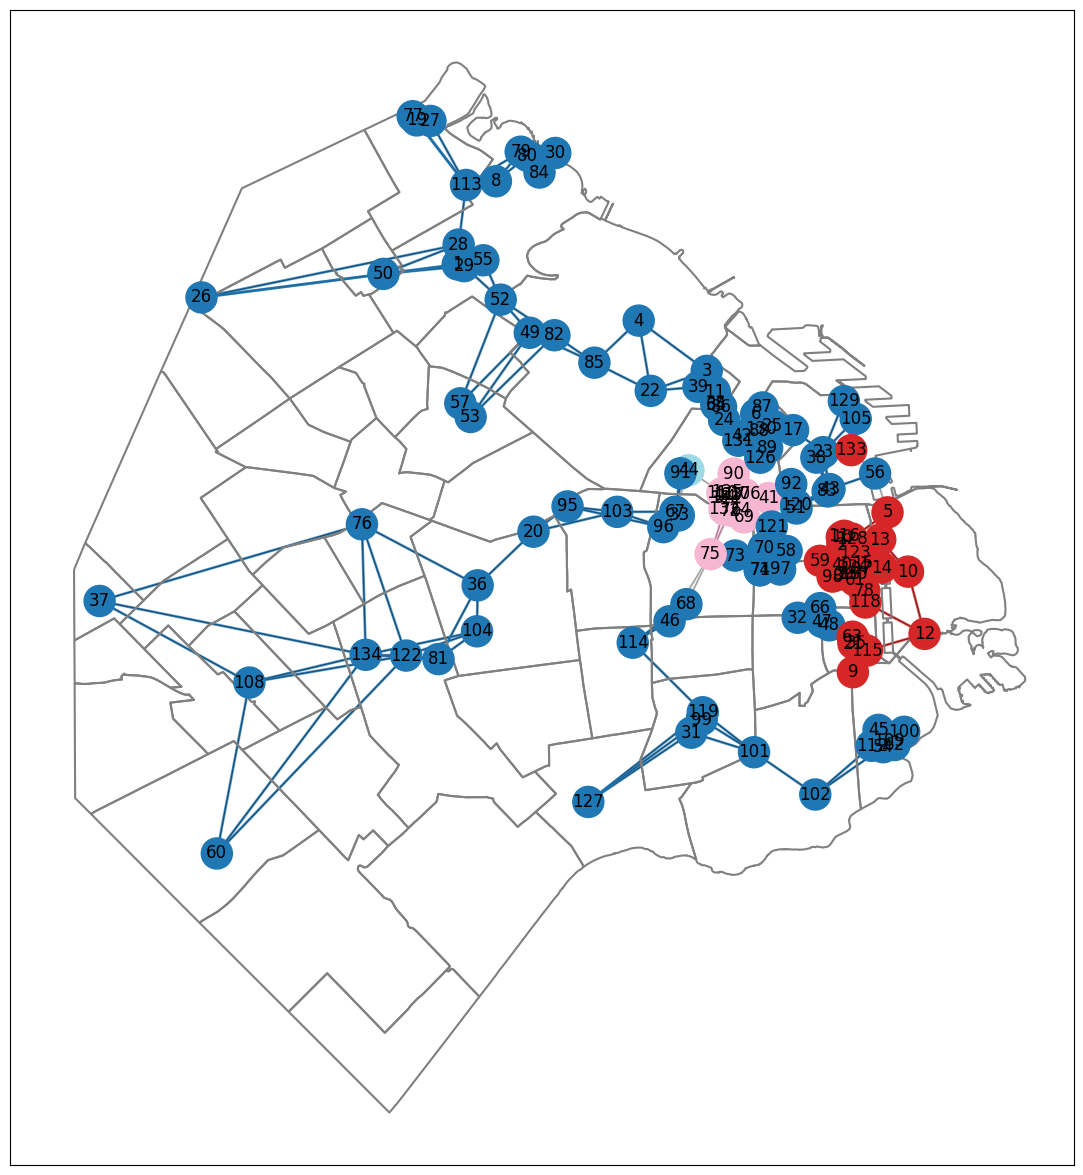

In [544]:
import template_funciones_2 as tf2
import matplotlib.patches as mpatches
#agrego la matriz de adyacencia nueva
adyacencias_m[50] = construye_adyacencia(D,50)
adyacencias_m_sim = {key: 0.5*(np.matmul(value,value.T)) for key, value in adyacencias_m.items()}

#recalculo los grafos con las matrices simétricas
grafos_m = {}
valores_m = [3,5,10,50]
for m in valores_m:
    grafos_m[m] = nx.from_numpy_array(adyacencias_m[m])

#remuevo auto-aristas para todos los grafos
for g in grafos_m.values():
    g.remove_edges_from(nx.selfloop_edges(g))

comunidades_m_sim = {}
for m in valores_m:
    comunidades_m_sim[m] = tf2.modularidad_iterativo(adyacencias_m_sim[m_fijo], tf2.calcula_R(adyacencias_m_sim[m]))

print(comunidades_m_sim)

edge_colors, color_por_nodo = tf2.graficar_comunidades_en_grafo(grafos_m[3],comunidades_m_sim[3])

# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

# Visualización de la red en el mapa
fig, ax = plt.subplots(figsize=(15, 15)) 
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(grafos_m[3],G_layout,ax=ax,node_color=[color_por_nodo.get(nodo, "#cccccc") for nodo in G.nodes()],node_size=500) # Graficamos los museos
nx.draw_networkx_edges(
    G,
    G_layout,
    edge_color=edge_colors,
    width=2.0,  # mas gruesas para destacar
    alpha=0.7,
)



